In [1]:
import diode_loader as dloader

2022-10-02 14:29:10.028640: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
data = dloader.generate_dataframe("./splits/diode_train.csv")
data

images  \
0      train/outdoor/scene_00018/scan_00174/00018_001...   
1      train/indoors/scene_00002/scan_00023/00002_000...   
2      train/outdoor/scene_00018/scan_00180/00018_001...   
3      train/indoors/scene_00006/scan_00057/00006_000...   
4      train/outdoor/scene_00011/scan_00102/00011_001...   
...                                                  ...   
25453  train/indoors/scene_00003/scan_00027/00003_000...   
25454  train/indoors/scene_00006/scan_00067/00006_000...   
25455  train/outdoor/scene_00014/scan_00132/00014_001...   
25456  train/outdoor/scene_00017/scan_00166/00017_001...   
25457  train/outdoor/scene_00016/scan_00150/00016_001...   

                                                   depth  \
0      train/outdoor/scene_00018/scan_00174/00018_001...   
1      train/indoors/scene_00002/scan_00023/00002_000...   
2      train/outdoor/scene_00018/scan_00180/00018_001...   
3      train/indoors/scene_00006/scan_00057/00006_000...   
4      train/outdoor/scene_00011/scan_00102/00011_001...   
...                                                  ...   
25453  train/indoors/scene_00003/scan_00027/00003_000...   
25454  train/indoors/scene_00006/scan_00067/00006_000...   
25455  train/outdoor/scene_00014/scan_00132/00014_001...   
25456  train/outdoor/scene_00017/scan_00166/00017_001...   
25457  train/outdoor/scene_00016/scan_00150/00016_001...   

                                              depth_mask  
0      train/outdoor/scene_00018/scan_00174/00018_001...  
1      train/indoors/scene_00002/scan_00023/00002_000...  
2      train/outdoor/scene_00018/scan_00180/00018_001...  
3      train/indoors/scene_00006/scan_00057/00006_000...  
4      train/outdoor/scene_00011/scan_00102/00011_001...  
...                                                  ...  
25453  train/indoors/scene_00003/scan_00027/00003_000...  
25454  train/indoors/scene_00006/scan_00067/00006_000...  
25455  train/outdoor/scene_00014/scan_00132/00014_001...  
25456  train/outdoor/scene_00017/scan_00166/00017_001...  
25457  train/outdoor/scene_00016/scan_00150/00016_001...  

[25458 rows x 3 columns]

In [25]:
index = 10
image = data["images"][index]
depth = data["depth"][index]
depth_mask = data["depth_mask"][index]

img = dloader.load_color(image)
img = (img - img.min()) / (img.max() - img.min())

d = dloader.load_depth(depth, depth_mask)
d = (d - d.min()) / (d.max() - d.min())

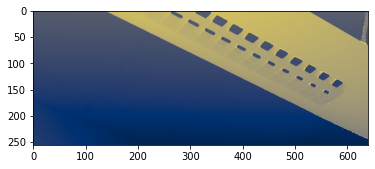

In [26]:
import matplotlib.pyplot as plt
plt.imshow(d, cmap="cividis_r")

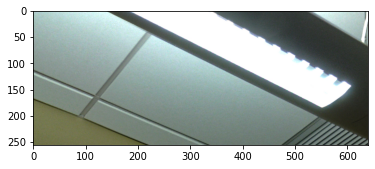

In [27]:
plt.imshow(img)

# DataLoader

In [10]:
import diode
import diode_loader as dloader
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [11]:
train = dloader.generate_dataframe("./splits/diode_train.csv")
train_generator = diode.DataGenerator(train, batch_size=64)

In [8]:
# for i in range(len(train_generator)):
#     print(f"{i}/{len(train_generator)}")
#     loader = train_generator.__getitem__(i)

loader = train_generator.__getitem__(5)

In [4]:
loader[0].shape

(64, 256, 640, 3)

In [5]:
loader[1][0].max()

1.0

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
1.0 1.0


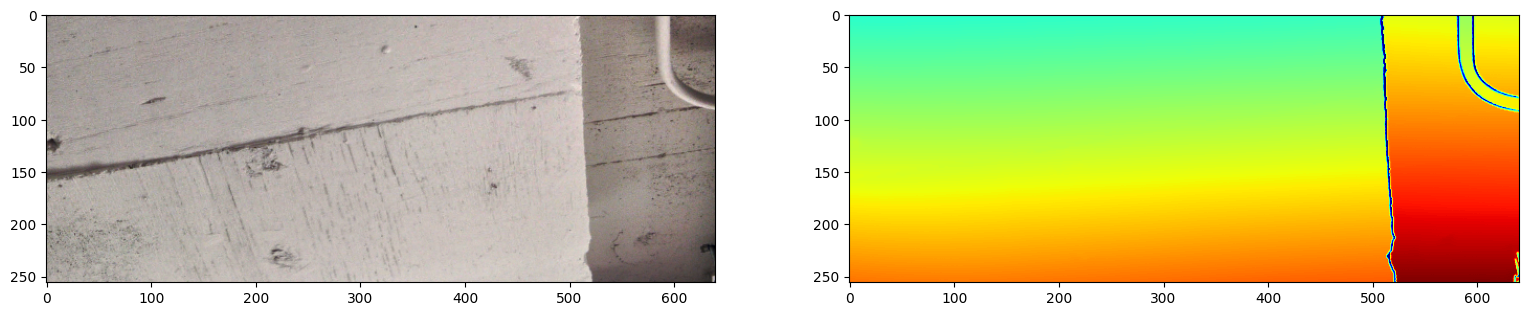

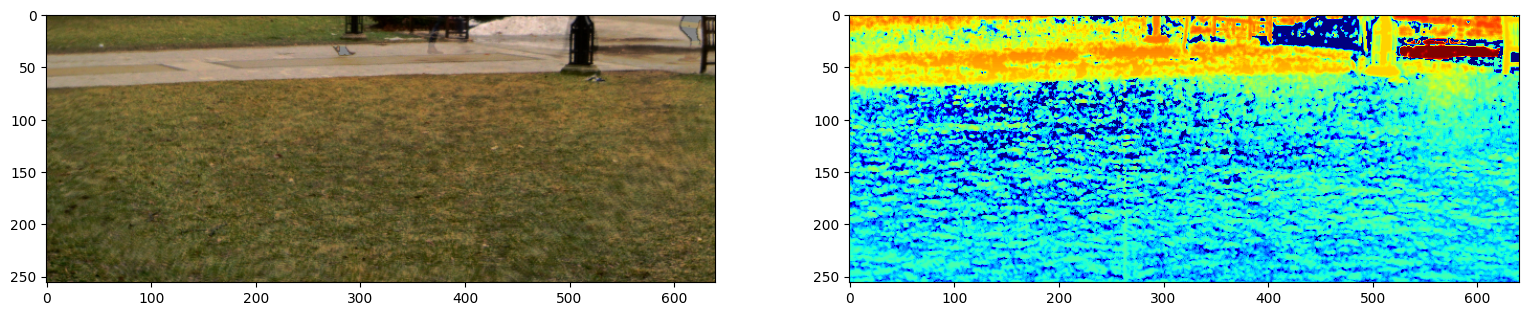

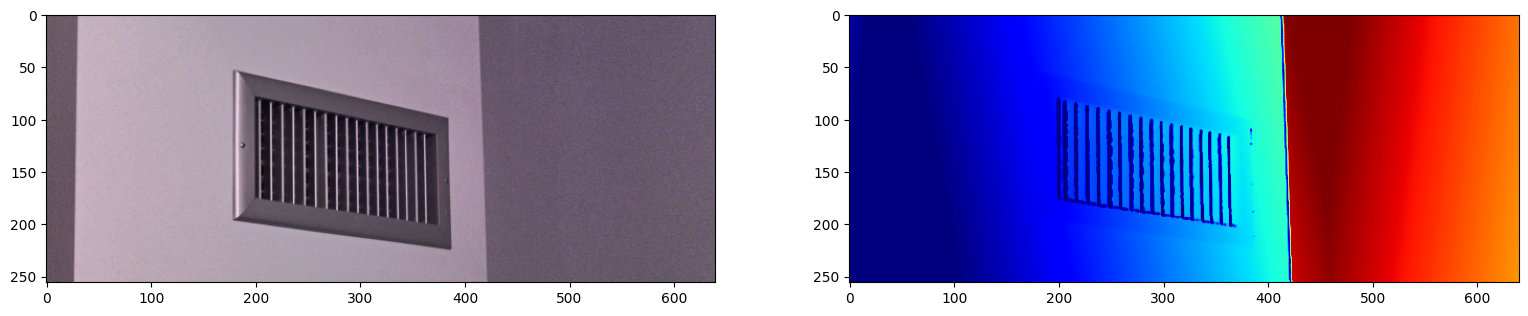

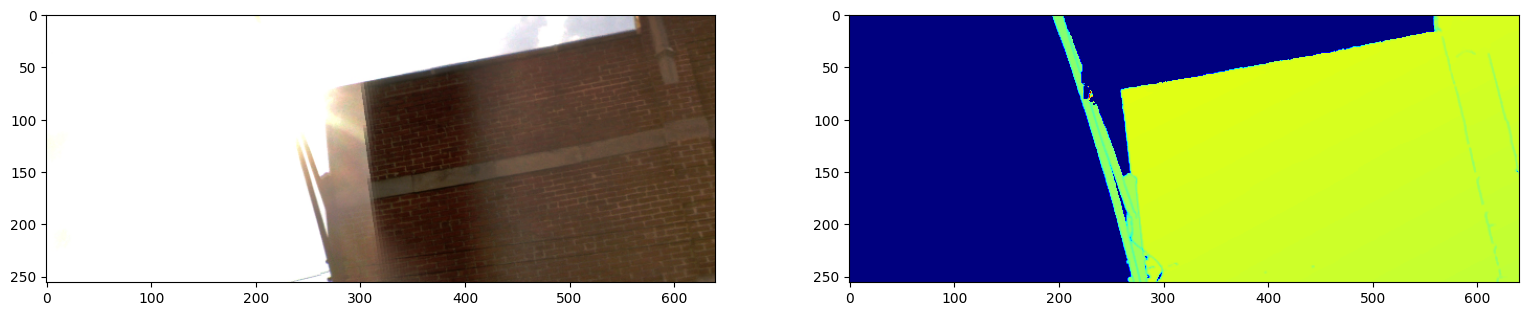

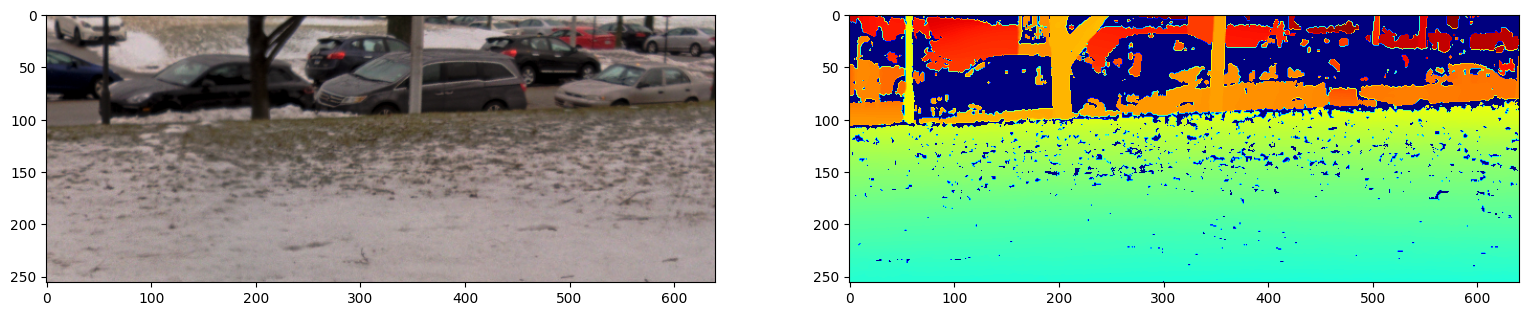

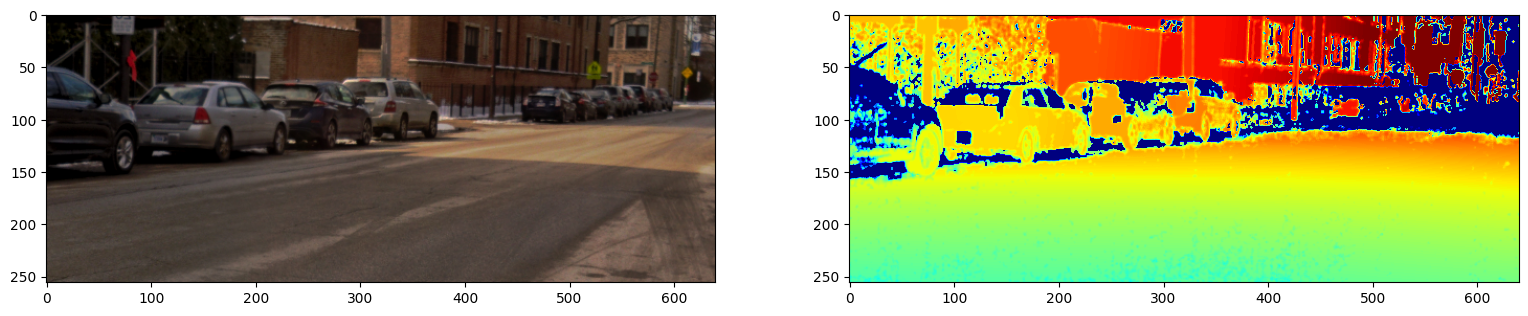

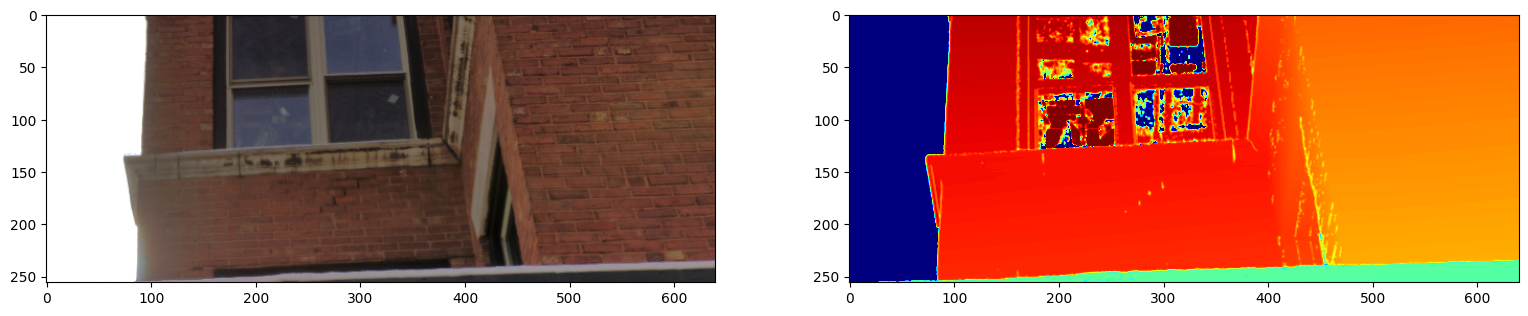

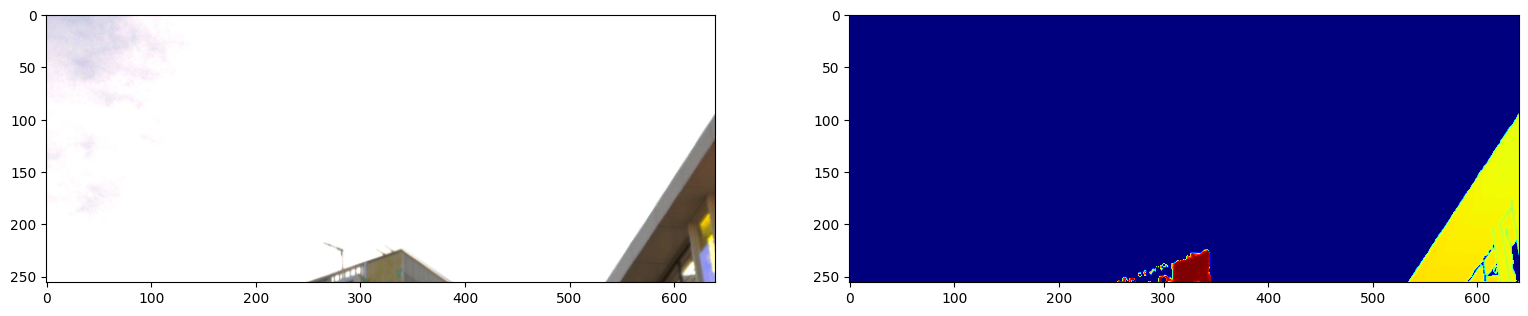

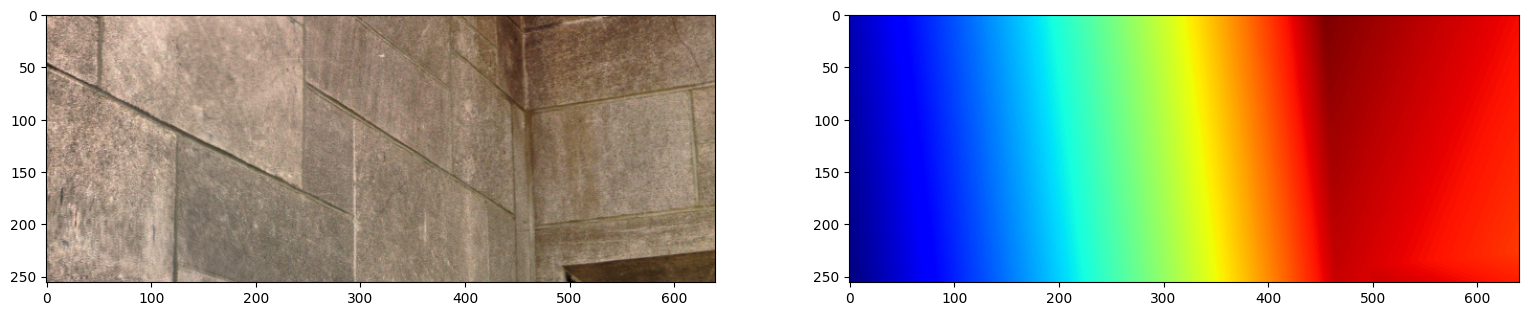

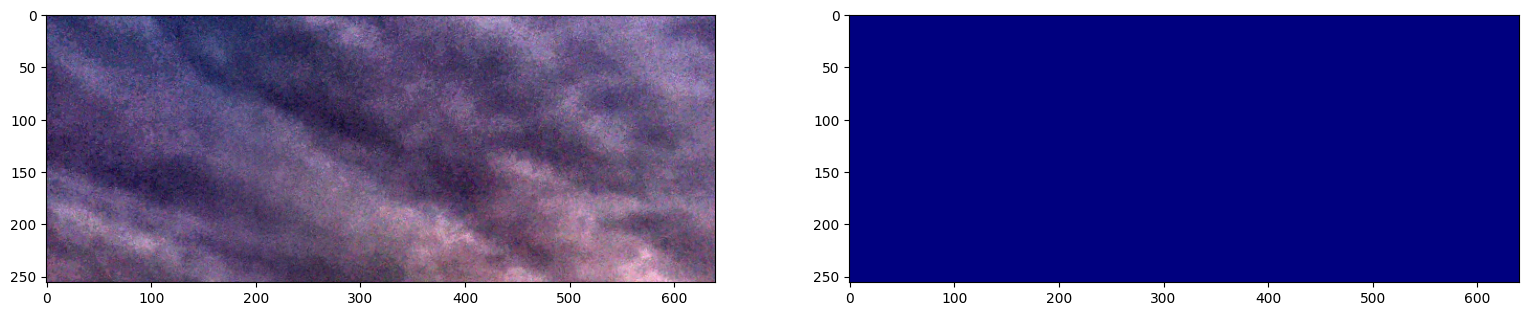

In [6]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.figure(figsize=(19,10))
    plt.subplot(1,2,1)
    plt.imshow(loader[0][i+10])
    plt.subplot(1,2,2)
    
    cmap = plt.cm.jet
    cmap.set_bad(color='black')
    plt.imshow(loader[1][i+10], cmap=cmap)
    print(loader[1][i+10].min(), loader[1][i+10].max())

# Results

In [19]:
from models.TCSVT import *
from utils import loss_function, accuracy_function, new_loss_function
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"
keras.backend.clear_session()

custom_func = {"new_loss_function": new_loss_function, "loss_function": loss_function, "accuracy_function": accuracy_function, "DownSampling": DownSampling, "UpSampling": UpSampling, "Scene_Understanding": Scene_Understanding }

model = tf.keras.models.load_model('./wnet_4.h5', custom_objects=custom_func)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 320, 24) 672         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 320, 24) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 160, 24)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [21]:
test = dloader.generate_dataframe("./splits/diode_val.csv")
test_generator = diode.DataGenerator(test, batch_size=30)

In [22]:
loader = test_generator.__getitem__(1)

In [125]:
i = 21
img = loader[0][i]
depth = loader[1][i]

In [126]:
import numpy as np
print(img.min(), img.max())
pred = model.predict(np.expand_dims(img, axis=0))

0.0 1.0


0.004602275 0.9968045


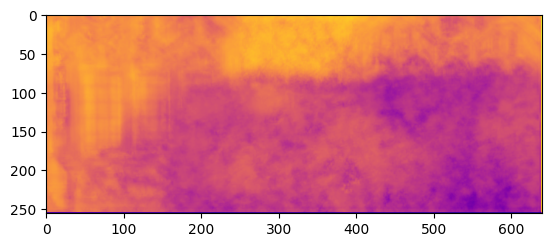

In [127]:
import matplotlib.pyplot as plt

print(pred.min(), pred.max())

cmap = plt.cm.jet
cmap.set_bad(color='black')
plt.imshow(np.squeeze(pred), cmap="plasma")

0.0 1.0


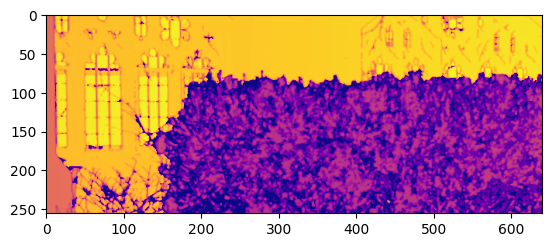

In [128]:
print(depth.min(), depth.max())

cmap = plt.cm.jet
cmap.set_bad(color='black')
plt.imshow(np.squeeze(depth), cmap="plasma")

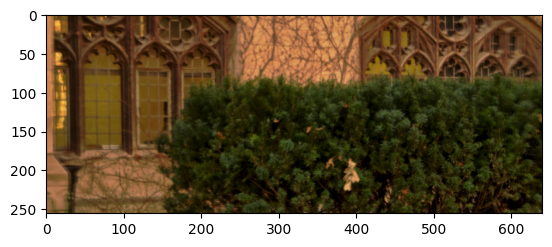

In [129]:
plt.imshow(img)

In [78]:
depth.min()

0.0

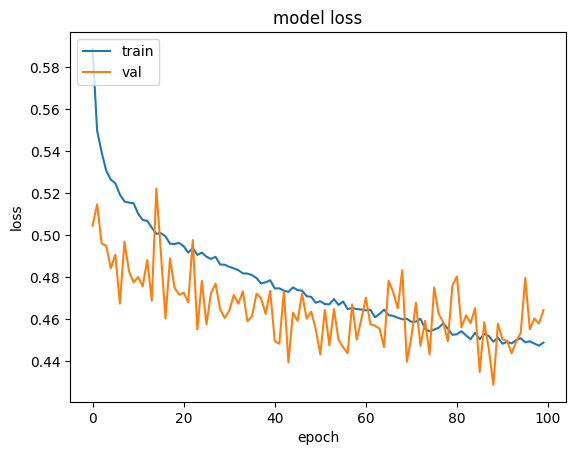

In [132]:
import pickle
import matplotlib.pyplot as plt


with open("wnet_4.history", "rb") as file:
    history = pickle.load(file)

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()